# Deep Dive into Similar Strings Progress through the Model

> Strings like `my most gr` and `ur most gr` produce very similar block intermediates at the start of the model but diverge before the end. This notebook investigates what happens. 

In [ ]:
# | hide
%load_ext autoreload
%autoreload 2

In [ ]:
# | hide
from pathlib import Path
from typing import Callable, Dict, List, Optional, Iterable, Protocol, Sequence, Tuple, TypeVar, Type

In [ ]:
#| hide
from fastcore.test import *
from matplotlib.axes import Axes
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
import torch
from torch.nn import functional as F
from tqdm.auto import tqdm

In [ ]:
# | hide

from transformer_experiments.common.substring_generator import all_unique_substrings
from transformer_experiments.common.text_analysis import (
    build_next_token_map,
    SubstringFrequencyAnalysis,
    top_nonzero_tokens
)
from transformer_experiments.common.utils import (
    aggregate_by_string_key,
    DataWrapper,
    topk_across_batches,
)
from transformer_experiments.dataset_split import split_text_dataset
from transformer_experiments.datasets.tinyshakespeare import (
    TinyShakespeareDataSet,
)
from transformer_experiments.environments import get_environment
from transformer_experiments.models.transformer import (
    n_embed,
    n_layer,
    TransformerLanguageModel
)
from transformer_experiments.models.transformer_helpers import (
    unsqueeze_emb,
    EncodingHelpers,
    LogitsWrapper,
    TransformerAccessors
)
from transformer_experiments.trained_models.tinyshakespeare_transformer import (
    create_model_and_tokenizer
)
from transformer_experiments.experiments.block_internals import (
    BlockInternalsAccessors,
    BlockInternalsExperiment,
    BatchedBlockInternalsExperiment,
    BlockInternalsAnalysis,
    batch_cosine_sim,
)
from transformer_experiments.experiments.similar_strings import (
    SimilarStringsData,
    SimilarStringsExperiment,
    SimilarStringsResult
)
from transformer_experiments.experiments.logit_lens import LogitLens

In [ ]:
environment = get_environment()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
ts = TinyShakespeareDataSet(cache_file=environment.code_root / 'nbs/artifacts/input.txt')
m, tokenizer = create_model_and_tokenizer(
    saved_model_filename=environment.code_root / 'nbs/artifacts/shakespeare-20231112.pt',
    dataset=ts,
    device=device,
)
_, val_data = split_text_dataset(ts.text, tokenizer, train_pct=0.9, device=device)
encoding_helpers = EncodingHelpers(tokenizer, device)
accessors = TransformerAccessors(m, device)

In [ ]:
print(f"environment is {environment.name}")
print(f"device is {device}")

environment is local_mac
device is cpu


In [ ]:
if list((environment.data_root / 'block_internals_results/large_files/slen10/').glob('*')) == []:
    print("Run `make block_internals_slen10_dataset` in the project root to generate the required dataset")

In [ ]:
strings10 = all_unique_substrings(ts.text, 10)

In [ ]:
exp10 = BatchedBlockInternalsExperiment(
    eh=encoding_helpers,
    accessors=accessors,
    strings=strings10,
    output_dir=environment.data_root / 'block_internals_results/large_files/slen10/',
    batch_size=10000,
)

In [ ]:
prompt1 = 'my most gr'
prompt2 = 'ur most gr'

bia1 = BlockInternalsAccessors(prompt1, encoding_helpers, accessors)
bia2 = BlockInternalsAccessors(prompt2, encoding_helpers, accessors)

Let's look at how the proj outputs for these diverge across the model:

In [ ]:
for block_idx in range(n_layer):
    proj_out1 = bia1.proj_output(block_idx)[0, -1, :]
    proj_out2 = bia2.proj_output(block_idx)[0, -1, :]

    print(f"Block {block_idx}: distance {torch.norm(proj_out1-proj_out2):.3f}, cosine sim {F.cosine_similarity(proj_out1, proj_out2, dim=-1):.3f}")



Block 0: distance 0.792, cosine sim 0.995
Block 1: distance 0.949, cosine sim 0.997
Block 2: distance 2.432, cosine sim 0.968
Block 3: distance 3.950, cosine sim 0.932
Block 4: distance 6.427, cosine sim 0.780
Block 5: distance 5.856, cosine sim 0.740


They get further apart and less cosine similar.

And same for ffwd output:

In [ ]:
for block_idx in range(n_layer):
    ffwd_out1 = bia1.ffwd_output(block_idx)[0, -1, :]
    ffwd_out2 = bia2.ffwd_output(block_idx)[0, -1, :]

    print(f"Block {block_idx}: distance {torch.norm(ffwd_out1-ffwd_out2):.3f}, cosine sim {F.cosine_similarity(ffwd_out1, ffwd_out2, dim=-1):.3f}")



Block 0: distance 0.140, cosine sim 1.000
Block 1: distance 0.443, cosine sim 0.999
Block 2: distance 0.746, cosine sim 0.997
Block 3: distance 1.767, cosine sim 0.991
Block 4: distance 2.762, cosine sim 0.985
Block 5: distance 3.446, cosine sim 0.995


They do get further apart but cosine similarity stays very close to 1. 

What does the model predict for these? 

In [ ]:
# What are the predicted outputs for these two:
tokens1 = encoding_helpers.tokenize_string(prompt1)
logits1, _ = m(tokens1)
logits1 = LogitsWrapper(logits1.detach(), tokenizer)

tokens2 = encoding_helpers.tokenize_string(prompt2)
logits2, _ = m(tokens2)
logits2 = LogitsWrapper(logits2.detach(), tokenizer)

logits1.topk_tokens(k=10)[0][-1], logits2.topk_tokens(k=10)[0][-1]

([('a', 0.4602494537830353),
  ('e', 0.35252559185028076),
  ('o', 0.09188850224018097),
  ('i', 0.09030349552631378),
  ('u', 0.004192721098661423),
  ('y', 0.0007521358784288168),
  ('r', 6.647213740507141e-05),
  ('l', 3.957989065384027e-06),
  ('v', 2.812936827467638e-06),
  ('w', 2.738903503995971e-06)],
 [('a', 0.42030981183052063),
  ('e', 0.3680994510650635),
  ('o', 0.10530176013708115),
  ('i', 0.1002618744969368),
  ('u', 0.0053354003466665745),
  ('y', 0.0005905701545998454),
  ('r', 6.933557597221807e-05),
  ('l', 6.059422503312817e-06),
  ('w', 4.522385552263586e-06),
  ('n', 2.6605287075653905e-06)])

These are extremely close.

In [ ]:
torch.norm(logits1.probs() - logits2.probs()), torch.norm(logits1.logits - logits2.logits)

(tensor(0.7939), tensor(20.7882))

In [ ]:
def imshow_tensor_in_chunks(
    x: torch.Tensor,
    n_chunks: int = 6,
    n_embed: int = n_embed,
    axes: Sequence[Axes] = [],
    min: Optional[float] = None,
    max: Optional[float] = None,
):
    if len(axes) == 0:
        fig, axes = plt.subplots(n_chunks, 1, figsize=(24, 16))
    else:
        assert len(axes) == n_chunks
    if x.dim() == 1:
        x = x.unsqueeze(dim=0)

    assert x.dim() == 2, 'x must be 2D'
    N, C = x.shape
    assert C == n_embed, f'C must be {n_embed}'
    assert C % n_chunks == 0, 'C must be divisible by n_chunks'

    # Get the min and max of the whole tensor - we'll use these to set the clim
    # values to be the same for all images (even though each one will have its
    # own colorbar)
    if min is None:
        min = x.flatten().min().item()
    if max is None:
        max = x.flatten().max().item()

    chunk_size = C // n_chunks
    for i in range(n_chunks):
        im = axes[i].imshow(
            x[:, i * chunk_size : (i + 1) * chunk_size].detach().numpy(),
            cmap='viridis',
            interpolation='none',
        )
        im.set_clim(min, max)
        axes[i].set_xlabel('Embedding Dimension', fontsize=12)
        axes[i].set_xticks(range(0, chunk_size, 10))
        axes[i].set_xticklabels(range(i * chunk_size, (i + 1) * chunk_size, 10))
        axes[i].set_ylabel('Position', fontsize=12)
        axes[i].set_yticks(range(N))
        plt.colorbar(im, ax=[axes[i]], location='top')

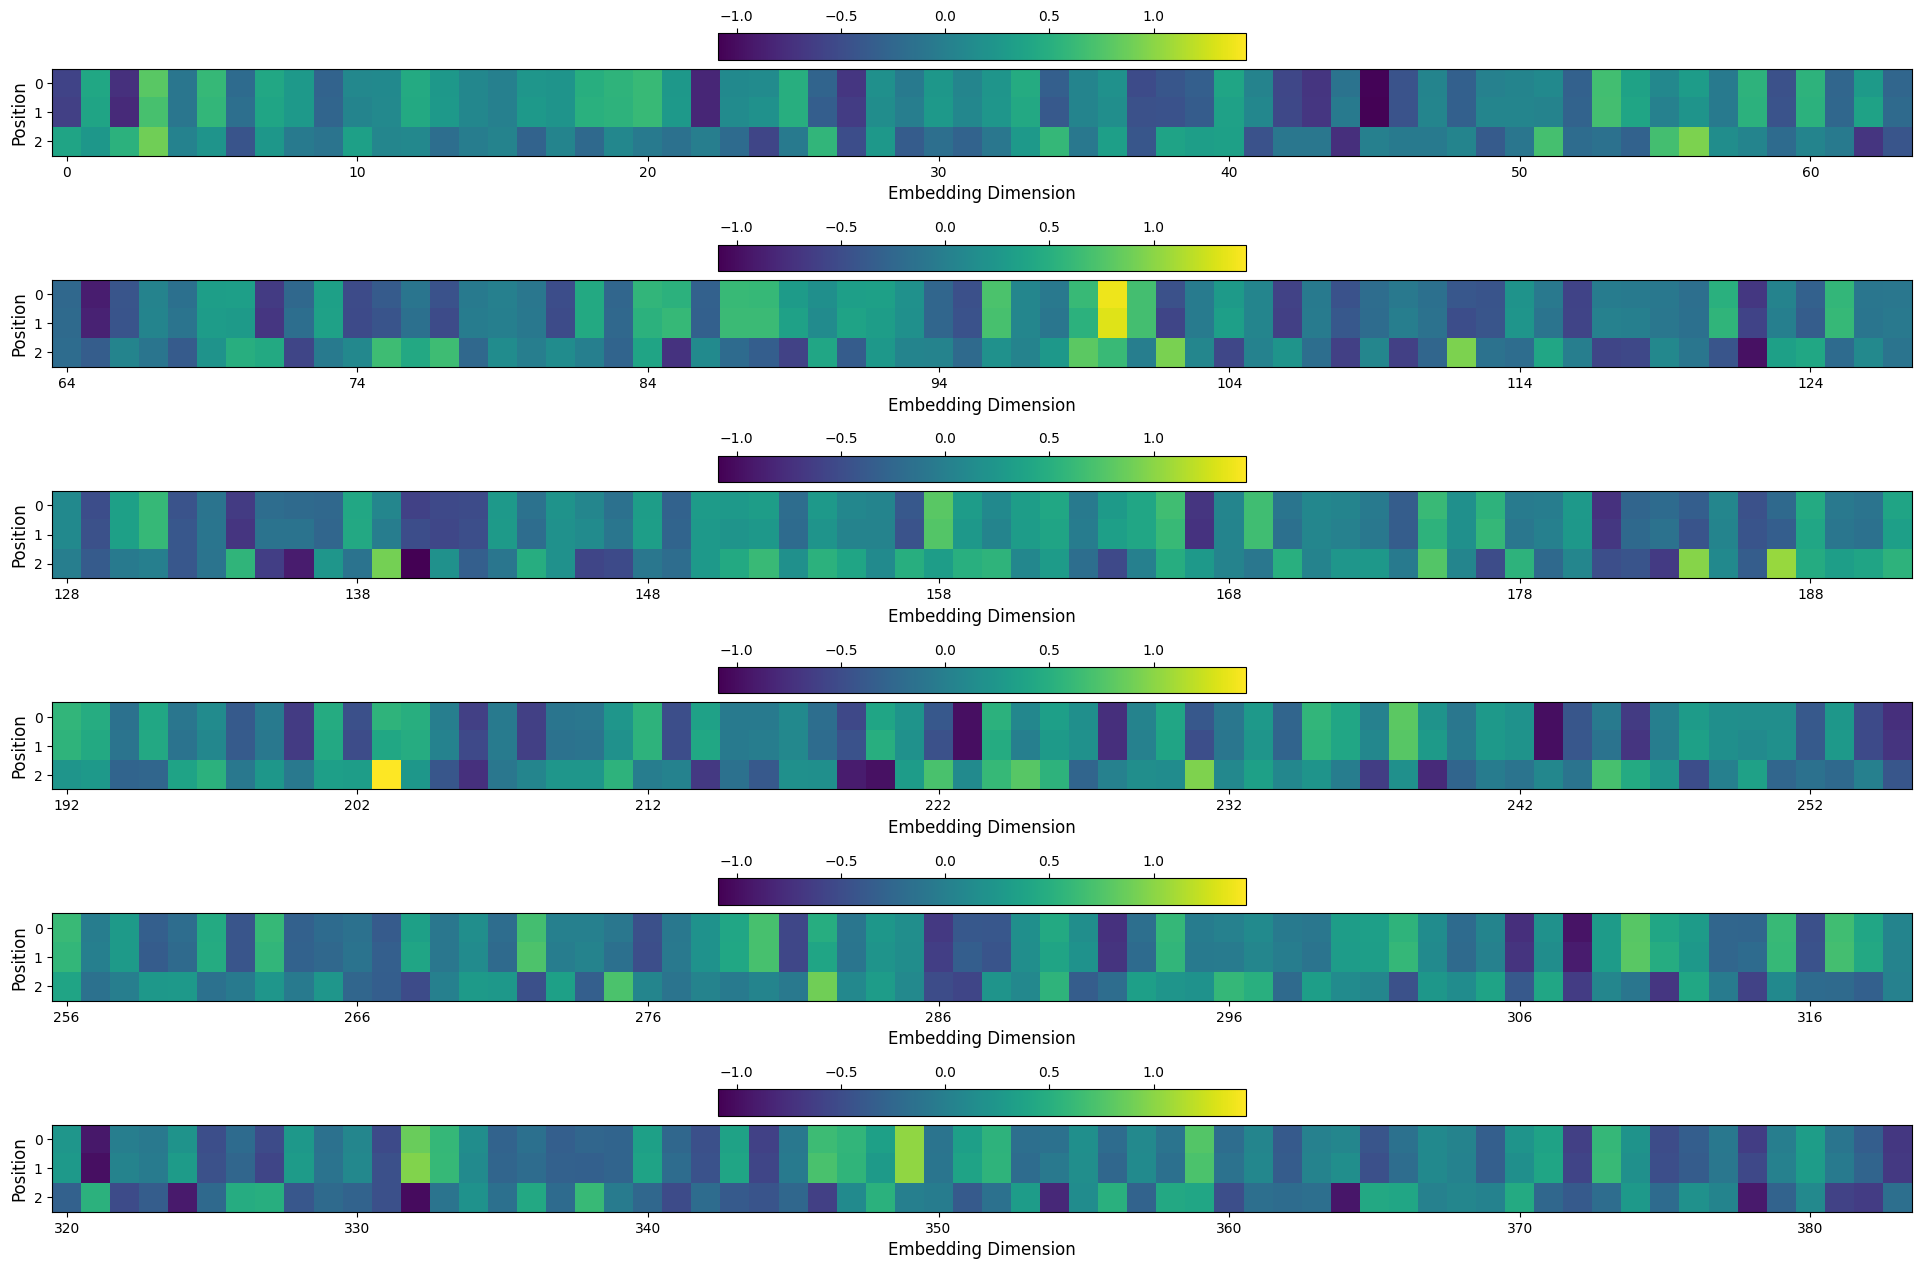

In [ ]:
block_idx = 0
proj_out1 = bia1.proj_output(block_idx=block_idx)[0, -1, :]
proj_out2 = bia2.proj_output(block_idx=block_idx)[0, -1, :]
x = torch.stack([
    proj_out1,
    proj_out2,
    (proj_out1 - proj_out2) * 10,
])
imshow_tensor_in_chunks(x)

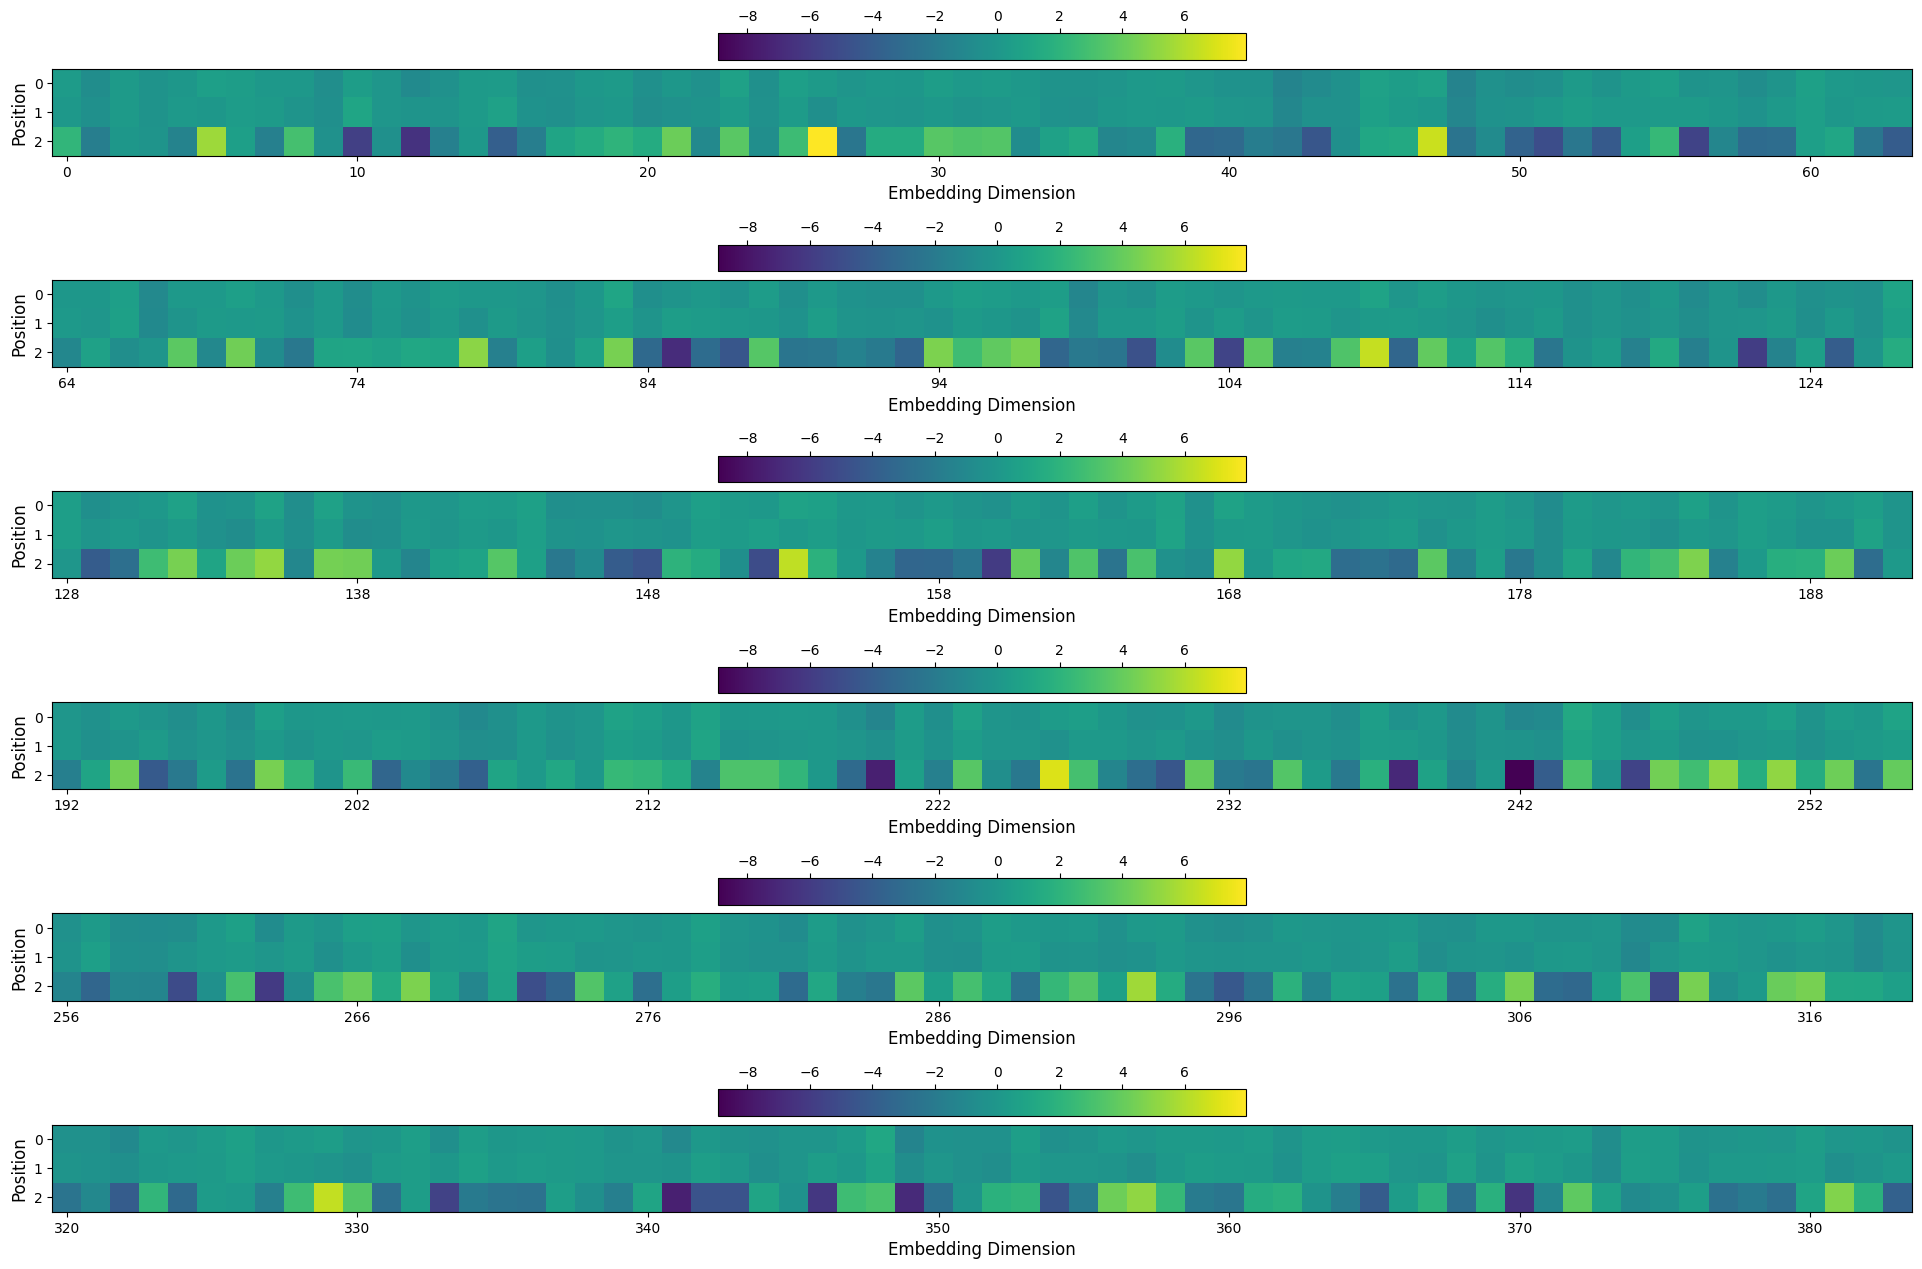

In [ ]:
block_idx = 5
proj_out1 = bia1.proj_output(block_idx=block_idx)[0, -1, :]
proj_out2 = bia2.proj_output(block_idx=block_idx)[0, -1, :]
x = torch.stack([
    proj_out1,
    proj_out2,
    (proj_out1 - proj_out2) * 10,
])
imshow_tensor_in_chunks(x)


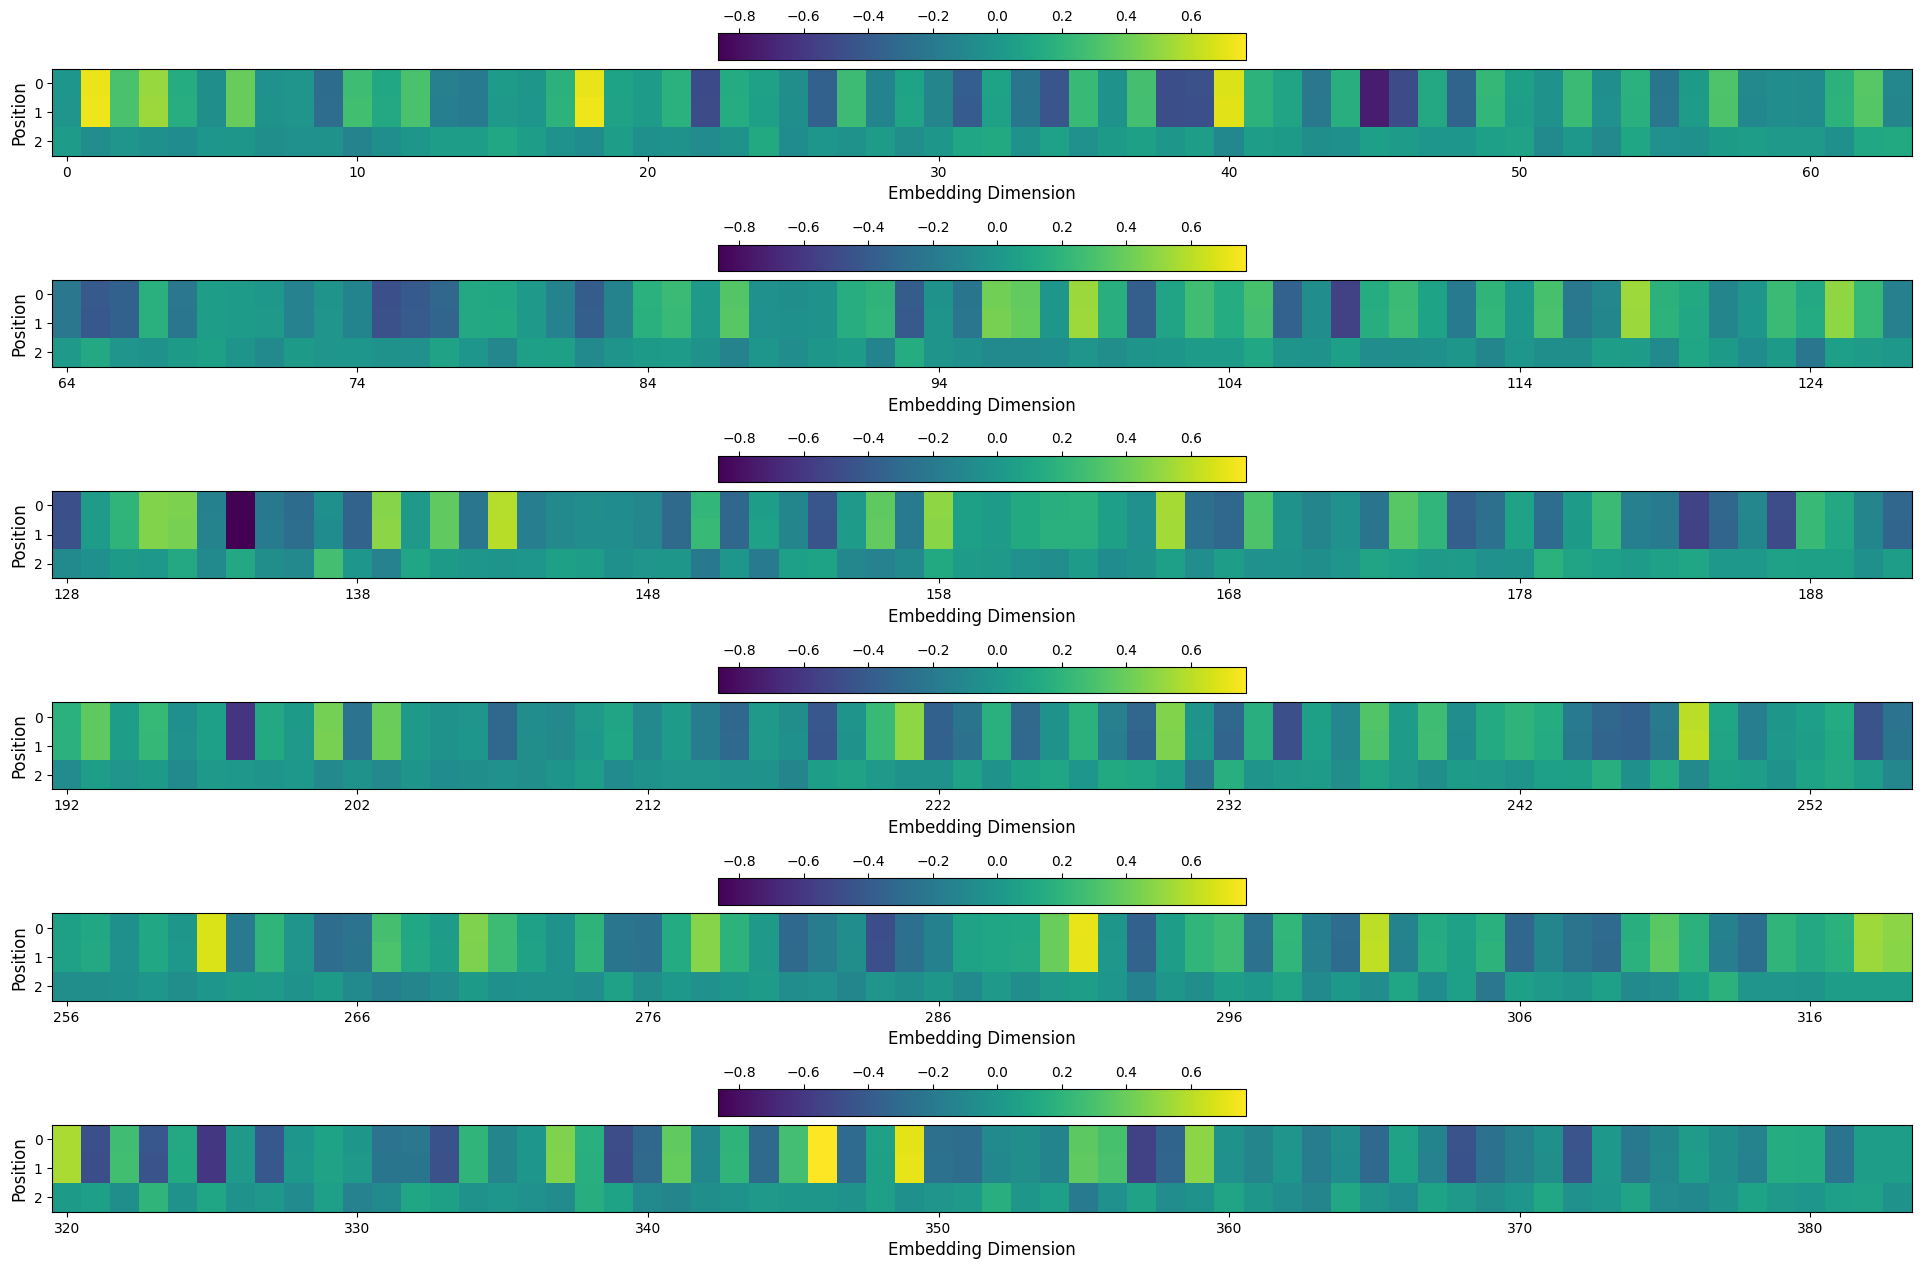

In [ ]:
block_idx = 0
ffwd_out1 = bia1.ffwd_output(block_idx=block_idx)[0, -1, :]
ffwd_out2 = bia2.ffwd_output(block_idx=block_idx)[0, -1, :]
x = torch.stack([
    ffwd_out1,
    ffwd_out2,
    (ffwd_out1 - ffwd_out2) * 10,
])
imshow_tensor_in_chunks(x)

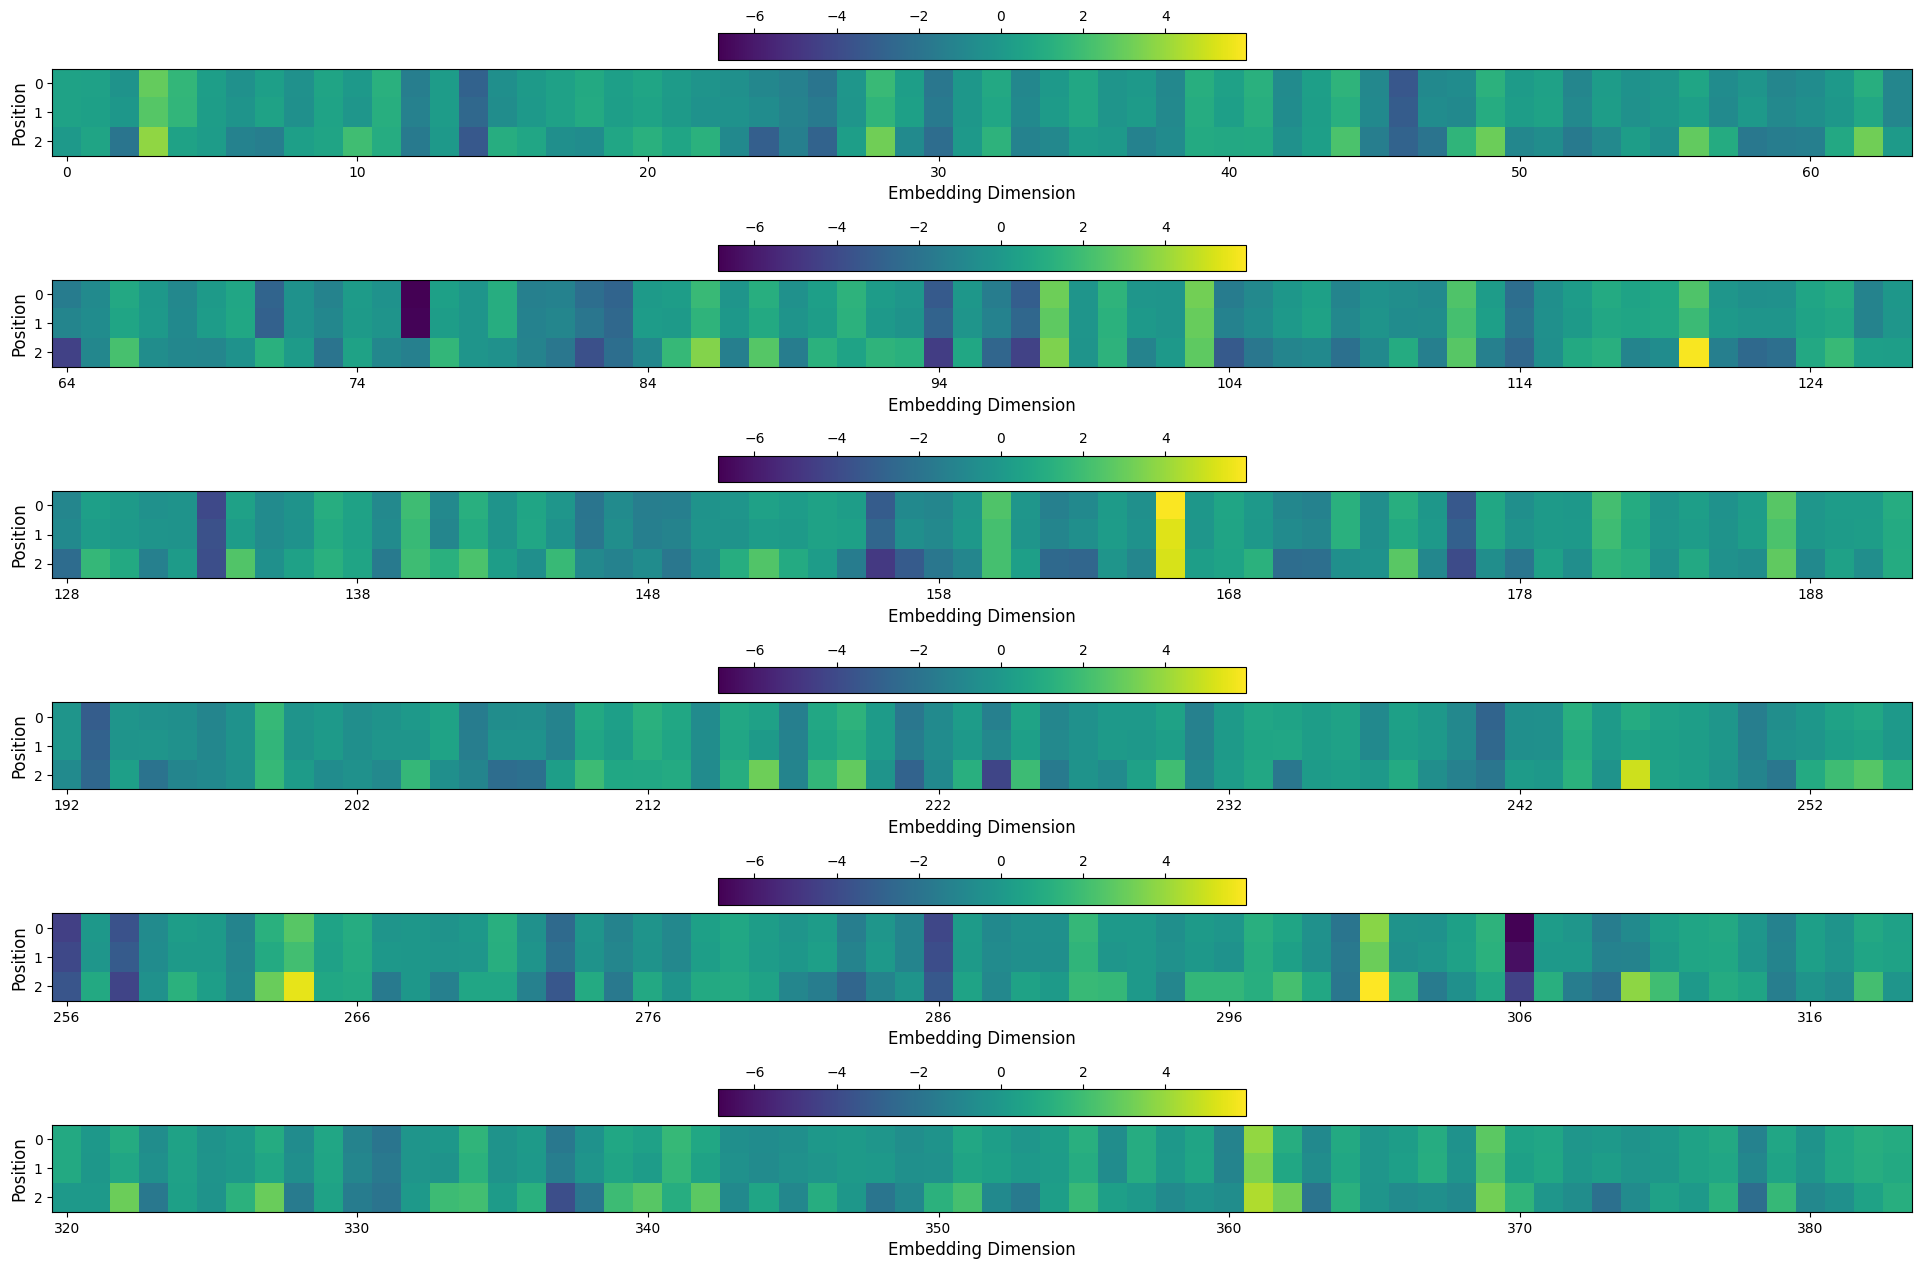

In [ ]:
block_idx = 5
ffwd_out1 = bia1.ffwd_output(block_idx=block_idx)[0, -1, :]
ffwd_out2 = bia2.ffwd_output(block_idx=block_idx)[0, -1, :]
x = torch.stack([
    ffwd_out1,
    ffwd_out2,
    (ffwd_out1 - ffwd_out2) * 10,
])
imshow_tensor_in_chunks(x)

In [ ]:
block_idx = 5
emb = bia1.io_accessors[block_idx].output('.')[0, -1, :]
zero_out_idx = n_embed - 1
emb2 = torch.cat([emb[:zero_out_idx], torch.zeros(n_embed-zero_out_idx)])
logits = LogitsWrapper(accessors.logits_from_embedding(unsqueeze_emb(emb)), tokenizer)
logits2 = LogitsWrapper(accessors.logits_from_embedding(unsqueeze_emb(emb2)), tokenizer)
logits.topk_tokens(k=10)[0][-1], logits2.topk_tokens(k=10)[0][-1]

([('a', 0.46024957299232483),
  ('e', 0.35252535343170166),
  ('o', 0.09188905358314514),
  ('i', 0.09030317515134811),
  ('u', 0.004192722495645285),
  ('y', 0.0007521368097513914),
  ('r', 6.647209374932572e-05),
  ('l', 3.957986336899921e-06),
  ('v', 2.8129350084782345e-06),
  ('w', 2.7389019123802427e-06)],
 [('a', 0.4389830529689789),
  ('e', 0.36069250106811523),
  ('i', 0.09699754416942596),
  ('o', 0.09658170491456985),
  ('u', 0.005966253113001585),
  ('y', 0.0006952937110327184),
  ('r', 6.115536234574392e-05),
  ('l', 3.7959973724355223e-06),
  ('v', 3.4647534903342603e-06),
  ('w', 2.603939492473728e-06)])